In [193]:
import numpy as np
import glob
import scipy.io as sio
import torch
from torch import nn
import random
import csv
import os
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import yaml
import time
import re
from XRF55_Dataset import XRF55_Datase 
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

In [3]:
torch.manual_seed(3407)

### Loda Data

In [4]:
train_dataset = XRF55_Datase(root_dir="D:\Data\XRF55\XRF_dataset", scene='all', is_train=True)
test_dataset = XRF55_Datase(root_dir="D:\Data\XRF55\XRF_dataset", scene='all', is_train=False)

In [5]:
def generate_none_empth_modality_list():
    modality_list = random.choices(
        [True, False],
        k= 1,
        weights=[50, 50]
    )
    wifi_ = random.choices(
        [True, False],
        k= 1,
        weights=[90, 10]
    )
    modality_list.append(wifi_[0])
    rfid_ = random.choices(
        [True, False],
        k= 1,
        weights=[60, 40]
    )
    modality_list.append(rfid_[0])
    # print(modality_list)
    if sum(modality_list) == 0:
        modality_list = generate_none_empth_modality_list()
        return modality_list
    else:
        return modality_list

def collate_fn_padd(batch):
    '''
    Padds batch of variable length

    dict_keys(['modality', 'scene', 'subject', 'action', 'idx', 'output', 
    'input_rgb', 'input_depth', 'input_lidar', 'input_mmwave'])
    '''
    ## get sequence lengths
    # for t in batch:
    #     print(t.keys())
    #     print(a)
    # #     # print(t[0].shape,t[1].shape)
    # kpts = []
    # [kpts.append(np.array(t['output'])) for t in batch]
    # kpts = torch.FloatTensor(np.array(kpts))
    labels = []
    [labels.append(float(t[3])) for t in batch]
    labels = torch.FloatTensor(labels)

    # mmwave
    mmwave_data = np.array([(t[2]) for t in batch ])
    mmwave_data = torch.FloatTensor(mmwave_data)

    # wifi-csi
    wifi_data = np.array([(t[0]) for t in batch ])
    wifi_data = torch.FloatTensor(wifi_data)

    # rfid
    rfid_data = np.array([(t[1]) for t in batch ])
    rfid_data = torch.FloatTensor(rfid_data)
    
    modality_list = generate_none_empth_modality_list()

    return mmwave_data, wifi_data, rfid_data, labels, modality_list

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_padd)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn_padd)

In [7]:
for data in train_dataloader:
    mmwave_data, wifi_data, rfid_data, labels, modality_list = data
    print(mmwave_data.shape, wifi_data.shape, rfid_data.shape, labels.shape, modality_list)
    break

torch.Size([16, 17, 256, 128]) torch.Size([16, 270, 1000]) torch.Size([16, 23, 148]) torch.Size([16]) [True, True, True]


### Model

In [8]:
import torch
from MI_model_5_3input_modified import modality_invariant_model
# from MI_model_6 import modality_invariant_model
# from MI_model import modality_invariant_model

model = modality_invariant_model(model_depth=4, num_classes=55)
model.cuda()

# mmwave_data = torch.randn(16, 17, 256, 128).cuda()
# wifi_data = torch.randn(16, 270, 1000).cuda()
# rfid_data = torch.randn(16, 23, 148).cuda()
# modality_list = [True, True, True]
# # modality_list = [True, False, True]
# # modality_list = [False, True, False]
# # modality_list = [True, True, True, True, True]
# # # # # # # modality_list = [False, False, False, False, False]

# # out = model(rgb_data, depth_data,  mmwave_data, lidar_data, wifi_data, modality_list)
# out = model(mmwave_data, wifi_data, rfid_data, modality_list)

# print(out.shape)
# # print(model)

modality_invariant_model(
  (feature_extractor): feature_extrator(
    (mmwave_extractor): mmwave_feature_extractor(
      (part): Sequential(
        (0): Conv2d(17, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, ker

In [9]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

32936183


### training 

In [202]:

def test(model, tensor_loader, criterion, device):
    model.eval()
    test_acc = 0
    test_loss = 0
    # random.seed(config['modality_existances']['val_random_seed'])
    random.seed(3407)
    i = True
    norm_layer = nn.LayerNorm(512).to(device)
    # X = numpy.random.rand(16, 512)
    # y = np.rando
    for data in tqdm(tensor_loader):
        start_time = time.time()
        mmwave_data, wifi_data, rfid_data, labels, modality_list = data
        # t1 = time.time()
        # load_time = t1 - start_time 
        mmwave_data = mmwave_data.to(device)
        wifi_data = wifi_data.to(device)
        rfid_data = rfid_data.to(device)
        labels.to(device)
        labels = labels.type(torch.LongTensor)
        modality_list = [False, True, False]
        outputs, emb = model(mmwave_data, wifi_data,  rfid_data, modality_list)
        outputs = outputs.type(torch.FloatTensor)
        outputs.to(device)

        # t2 = time.time()
        # forward_time = t2 - t1
        loss = criterion(outputs,labels)
        predict_y = torch.argmax(outputs,dim=1).to(device)
        accuracy = (predict_y == labels.to(device)).sum().item() / labels.size(0)
        test_acc += accuracy
        test_loss += loss.item() * labels.size(0)

        emb = torch.mean(emb, dim=1)
        emb = norm_layer(emb)
        
        emb = emb.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

        if i:
            X = emb
            y = labels
            i = False
        else:
            X = np.vstack((X, emb))
            y = np.hstack((y, labels))
        # t3 = time.time()
        # record_time = t3 - t2
        # print('load_time: ', load_time)
        # print('forward_time: ', forward_time)
        # print('record_time: ', record_time)
    test_acc = test_acc/len(tensor_loader)
    test_loss = test_loss/len(tensor_loader.dataset)
    print("validation accuracy:{:.4f}, loss:{:.5f}".format(float(test_acc),float(test_loss)))
    return test_acc, test_loss, X, y

In [203]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load('./HAR_13thSep.pt'))
model.eval()
test_acc, test_loss, X, y = test(model, test_dataloader, criterion, device)

100%|██████████| 207/207 [15:14<00:00,  4.42s/it]

validation accuracy:0.5728, loss:1.53564


In [204]:
print(X.shape, y.shape)

(6600, 512) (6600,)


In [205]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54], dtype=int64)

In [206]:
class_dict = {}
for i in range(55):
    class_dict[i] = []
for i in range(len(X)):
    class_dict[y[i]].append(X[i])


In [207]:
print(len(class_dict[0]))

120


In [208]:
for i in range(55):
    if i == 0:
        all_data = class_dict[i]
        all_label = [i]*len(class_dict[i])
    else:
        all_data = np.vstack((all_data, class_dict[i]))
        all_label += [i]*len(class_dict[i])
all_label = np.array(all_label)
print(all_data.shape, all_label.shape)

(6600, 512) (6600,)


In [209]:
np.save('./embeddings/W_data.npy', all_data)
np.save('./embeddings/W_label.npy', all_label)

In [75]:
all_data = np.load('./embeddings/R_W_data.npy')
all_label = np.load('./embeddings/R_W_label.npy')

In [210]:
n_components = 2
tsne = TSNE(n_components, verbose=1, perplexity=40, n_iter=300)
tsne_result = tsne.fit_transform(all_data)
print(tsne_result.shape)

c:\Users\Chen_Xinyan\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Chen_Xinyan\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6600 samples in 0.002s...
[t-SNE] Computed neighbors for 6600 samples in 0.697s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6600
[t-SNE] Computed conditional probabilities for sample 2000 / 6600
[t-SNE] Computed conditional probabilities for sample 3000 / 6600
[t-SNE] Computed conditional probabilities for sample 4000 / 6600
[t-SNE] Computed conditional probabilities for sample 5000 / 6600
[t-SNE] Computed conditional probabilities for sample 6000 / 6600
[t-SNE] Computed conditional probabilities for sample 6600 / 6600
[t-SNE] Mean sigma: 7.288321
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.354652
[t-SNE] KL divergence after 300 iterations: 2.360493
(6600, 2)


In [211]:
colors1 = plt.cm.tab20(np.linspace(0, 1, 20))
colors2 = plt.cm.tab20b(np.linspace(0, 1, 20))
colors3 = plt.cm.tab20c(np.linspace(0, 1, 5))
colors = np.vstack((colors1, colors2, colors3))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)



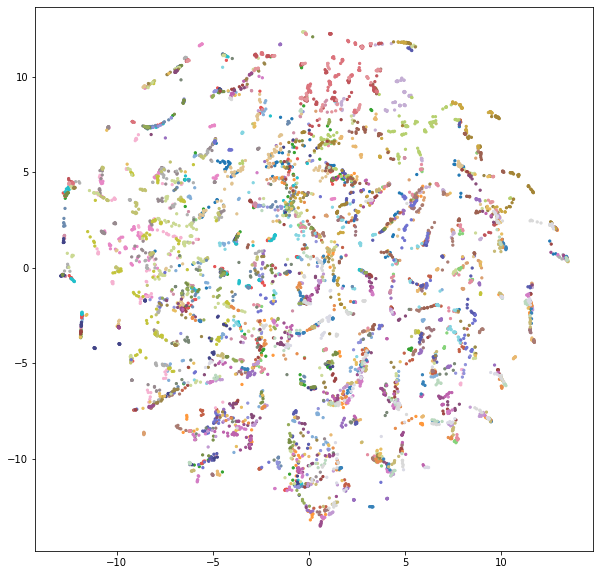

In [212]:
fig = plt.figure(figsize=(10, 10))
scatter = plt.scatter(tsne_result[:,0], tsne_result[:,1], s = 5,c=all_label,cmap=mymap)
# handles, _ = scatter.legend_elements(prop='colors')
# plt.legend(handles, labels)
plt.show()

In [213]:
np.save('./embeddings/W_tsne_300.npy', tsne_result)

In [224]:
R_W_all_data = np.load('./embeddings/19thAug/R_W_tsne_300.npy')
R_W_all_label = np.load('./embeddings/19thAug/R_W_label.npy')
R_W_score = calinski_harabasz_score(R_W_all_data, R_W_all_label)
print('calinski_harabasz_score:', R_W_score)
R_W_score = silhouette_score(R_W_all_data, R_W_all_label)
print('silhouette_score:', R_W_score)

calinski_harabasz_score: 1635.3631923371754
silhouette_score: 0.4967834


In [225]:
R_all_data = np.load('./embeddings/19thAug/R_tsne.npy')
R_all_label = np.load('./embeddings/19thAug/R_label.npy')
R_score = calinski_harabasz_score(R_all_data, R_all_label)
print('calinski_harabasz_score:', R_score)
R_score = silhouette_score(R_all_data, R_all_label)
print('silhouette_score:', R_score)

calinski_harabasz_score: 1320.3496401068242
silhouette_score: 0.40774307


In [226]:
W_all_data = np.load('./embeddings/19thAug/W_tsne_300.npy')
W_all_label = np.load('./embeddings/19thAug/W_label.npy')
W_score = calinski_harabasz_score(W_all_data, W_all_label)
print('calinski_harabasz_score:', W_score)
W_score = silhouette_score(W_all_data, W_all_label)
print('silhouette_score:', W_score)

calinski_harabasz_score: 67.28251699481608
silhouette_score: -0.23859288


### Draw

In [264]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

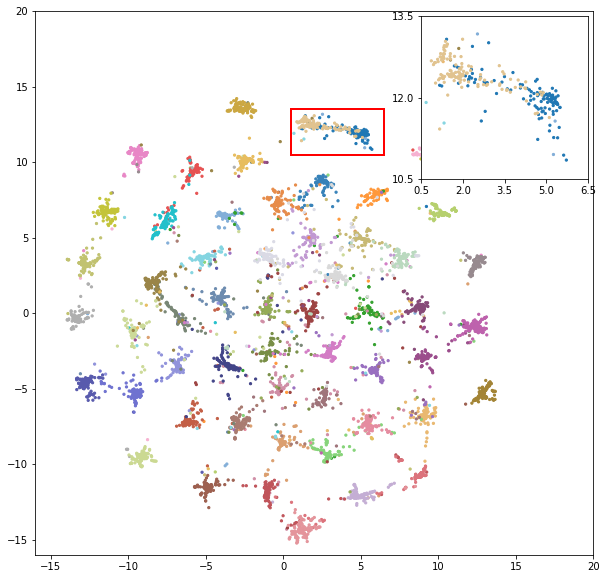

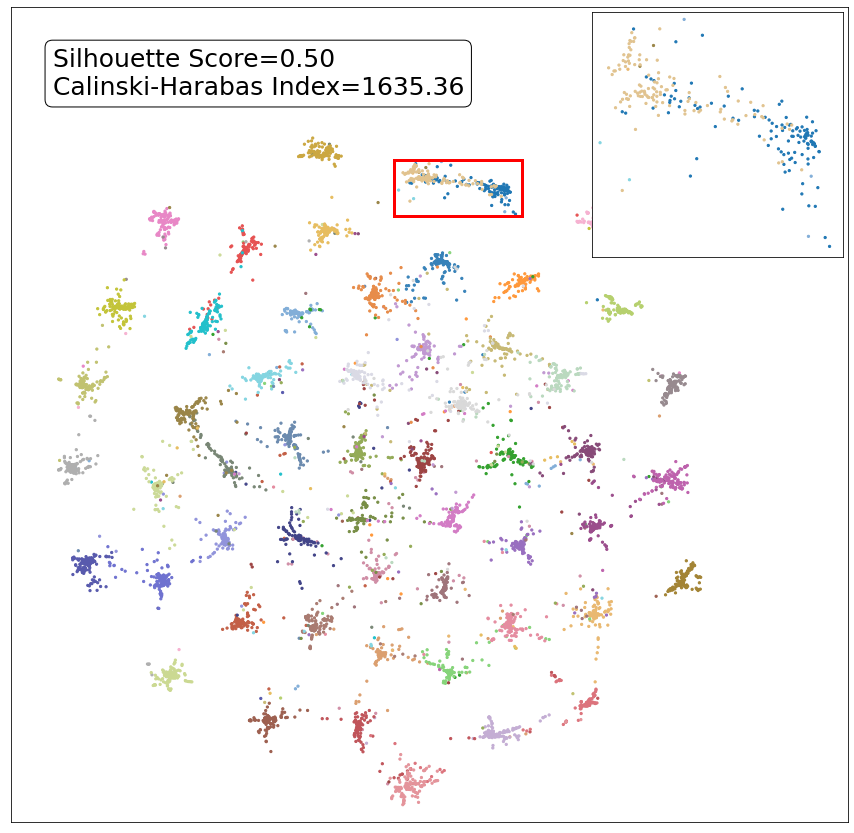

In [314]:

R_W_all_data = np.load('./embeddings/19thAug/R_W_tsne_300.npy')
R_W_all_label = np.load('./embeddings/19thAug/R_W_label.npy')
plot_tsne(R_W_all_data, R_W_all_label)

ch_score = calinski_harabasz_score(R_W_all_data, R_W_all_label)
s_score = silhouette_score(R_W_all_data, R_W_all_label)


colors1 = plt.cm.tab20(np.linspace(0, 1, 20))
colors2 = plt.cm.tab20b(np.linspace(0, 1, 20))
colors3 = plt.cm.tab20c(np.linspace(0, 1, 5))
colors = np.vstack((colors1, colors2, colors3))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
# fig = plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_xlim(-16, 20)
ax.set_ylim(-16, 20)
ax.set_xticks([])
ax.set_yticks([])
ax.scatter(R_W_all_data[:,0], R_W_all_data[:,1], s = 5,c=R_W_all_label,cmap=mymap)

axins = inset_axes(ax, width="30%", height="30%", loc="upper right")  # Customize the size and location

# Plot the same data in the inset plot
axins.scatter(R_W_all_data[:,0], R_W_all_data[:,1], s = 5,c=R_W_all_label,cmap=mymap)
x1, x2, y1, y2 = 0.5, 6, 10.75, 13.25  # Set the zoomed-in range
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([])
axins.set_yticks([])

# Add a rectangle to highlight the zoomed area on the main plot
rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', facecolor='none', lw=3)
ax.add_patch(rect)

# Optional: Add ticks to the inset axes
# axins.set_xticks(np.linspace(x1, x2, 5))
# axins.set_yticks(np.linspace(y1, y2, 3))
# ax.indicate_inset_zoom(axins, edgecolor="black")
# Display the plot

textstr = '\n'.join((
    'Silhouette Score=%.2f' % (s_score, ),
    'Calinski-Harabas Index=%.2f' % (ch_score, )
    ))

props = dict(boxstyle='round', facecolor="None", edgecolor='black',alpha=1)

ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=25,
        verticalalignment='top', bbox=props)


plt.show()


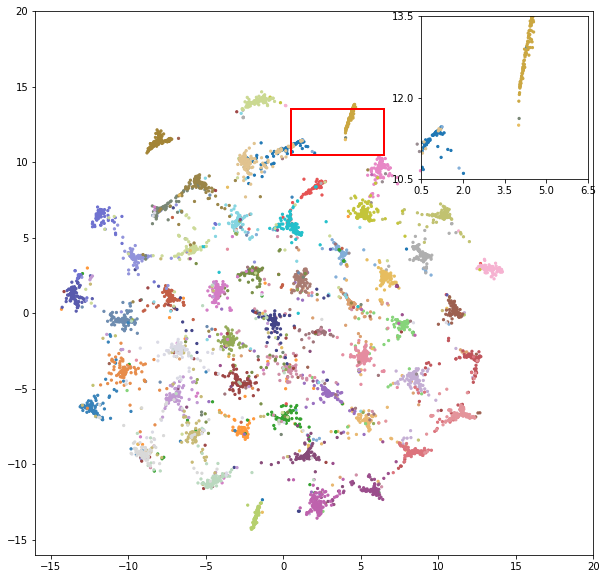

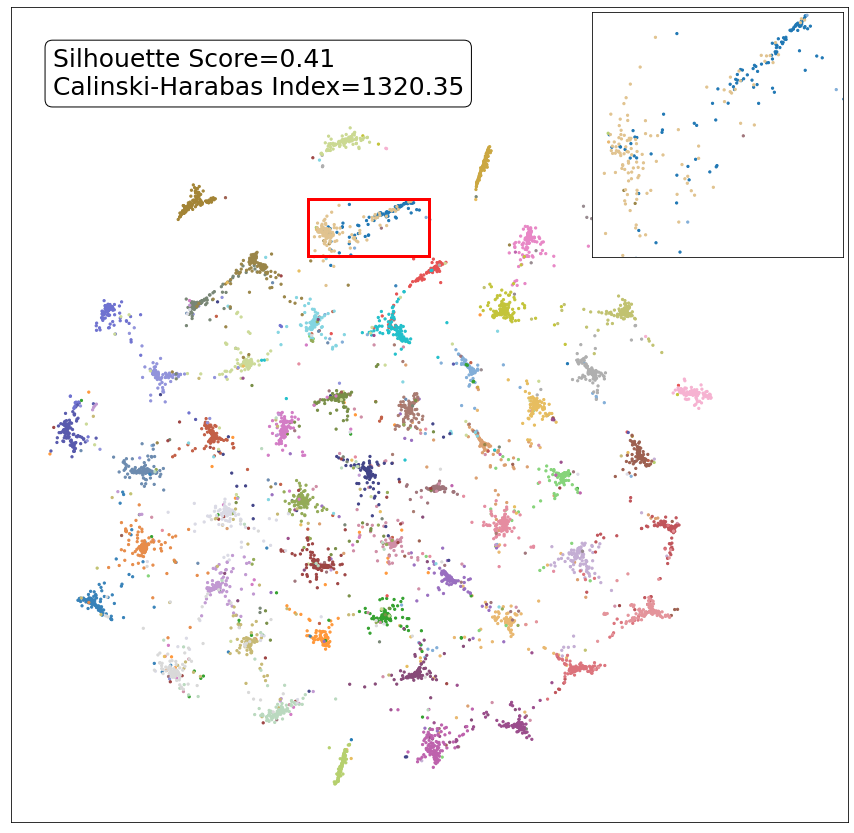

In [313]:

R_W_all_data = np.load('./embeddings/19thAug/R_tsne.npy')
R_W_all_label = np.load('./embeddings/19thAug/R_label.npy')
plot_tsne(R_W_all_data, R_W_all_label)

ch_score = calinski_harabasz_score(R_W_all_data, R_W_all_label)
s_score = silhouette_score(R_W_all_data, R_W_all_label)


colors1 = plt.cm.tab20(np.linspace(0, 1, 20))
colors2 = plt.cm.tab20b(np.linspace(0, 1, 20))
colors3 = plt.cm.tab20c(np.linspace(0, 1, 5))
colors = np.vstack((colors1, colors2, colors3))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
# fig = plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_xlim(-16, 20)
ax.set_ylim(-16, 20)
ax.set_xticks([])
ax.set_yticks([])
ax.scatter(R_W_all_data[:,0], R_W_all_data[:,1], s = 5,c=R_W_all_label,cmap=mymap)

axins = inset_axes(ax, width="30%", height="30%", loc="upper right")  # Customize the size and location

# Plot the same data in the inset plot
axins.scatter(R_W_all_data[:,0], R_W_all_data[:,1], s = 5,c=R_W_all_label,cmap=mymap)
x1, x2, y1, y2 = -3.2, 2, 9, 11.5  # Set the zoomed-in range
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([])
axins.set_yticks([])

# Add a rectangle to highlight the zoomed area on the main plot
rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', facecolor='none', lw=3)
ax.add_patch(rect)

# Optional: Add ticks to the inset axes
# axins.set_xticks(np.linspace(x1, x2, 5))
# axins.set_yticks(np.linspace(y1, y2, 3))
# ax.indicate_inset_zoom(axins, edgecolor="black")
# Display the plot

textstr = '\n'.join((
    'Silhouette Score=%.2f' % (s_score, ),
    'Calinski-Harabas Index=%.2f' % (ch_score, )
    ))

props = dict(boxstyle='round', facecolor="None", edgecolor='black',alpha=1)

ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=25,
        verticalalignment='top', bbox=props)


plt.show()

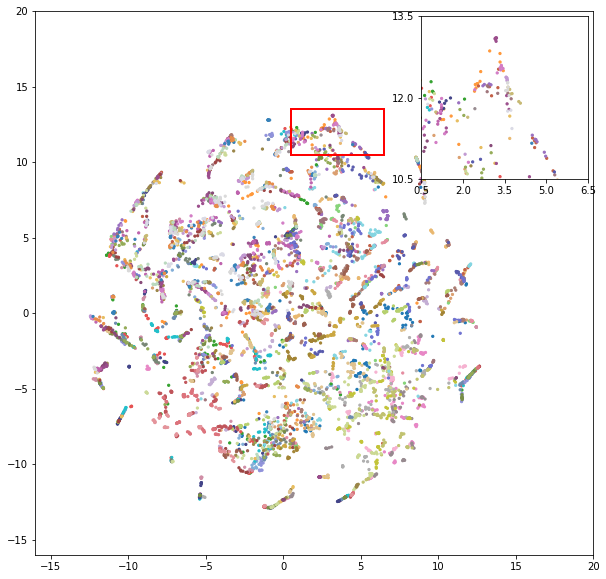

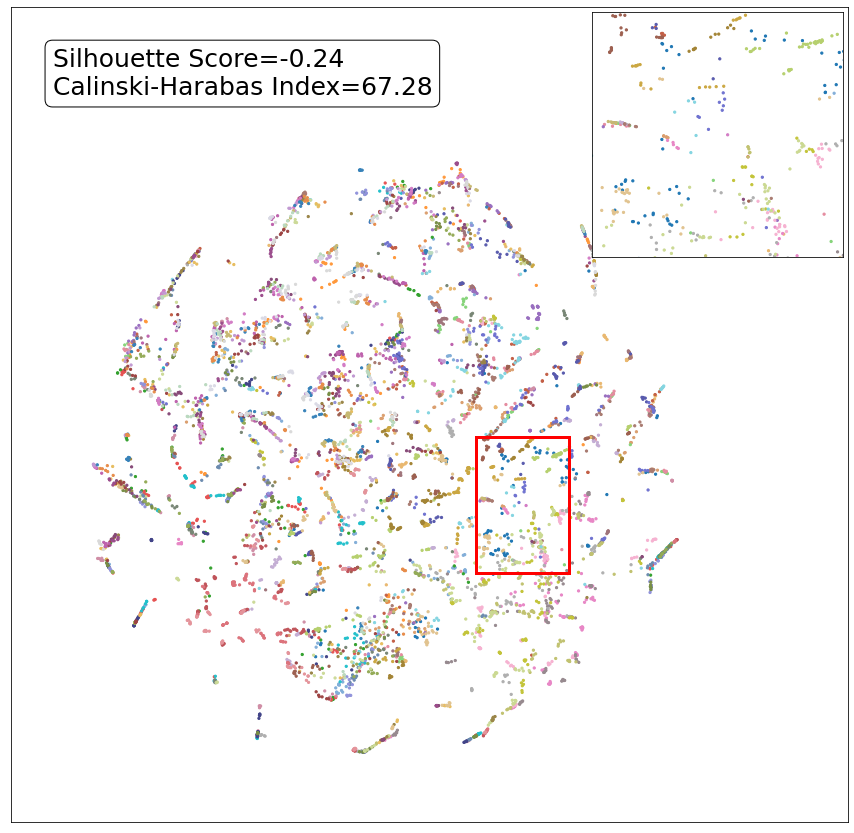

In [315]:

R_W_all_data = np.load('./embeddings/19thAug/W_tsne_300.npy')
R_W_all_label = np.load('./embeddings/19thAug/W_label.npy')
plot_tsne(R_W_all_data, R_W_all_label)

ch_score = calinski_harabasz_score(R_W_all_data, R_W_all_label)
s_score = silhouette_score(R_W_all_data, R_W_all_label)


colors1 = plt.cm.tab20(np.linspace(0, 1, 20))
colors2 = plt.cm.tab20b(np.linspace(0, 1, 20))
colors3 = plt.cm.tab20c(np.linspace(0, 1, 5))
colors = np.vstack((colors1, colors2, colors3))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
# fig = plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_xlim(-16, 20)
ax.set_ylim(-16, 20)
ax.set_xticks([])
ax.set_yticks([])
ax.scatter(R_W_all_data[:,0], R_W_all_data[:,1], s = 5,c=R_W_all_label,cmap=mymap)

axins = inset_axes(ax, width="30%", height="30%", loc="upper right")  # Customize the size and location

# Plot the same data in the inset plot
axins.scatter(R_W_all_data[:,0], R_W_all_data[:,1], s = 5,c=R_W_all_label,cmap=mymap)
x1, x2, y1, y2 = 4, 8, -5, 1  # Set the zoomed-in range
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([])
axins.set_yticks([])

# Add a rectangle to highlight the zoomed area on the main plot
rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', facecolor='none', lw=3)
ax.add_patch(rect)

# Optional: Add ticks to the inset axes
# axins.set_xticks(np.linspace(x1, x2, 4))
# axins.set_yticks(np.linspace(y1, y2, 6))
# ax.indicate_inset_zoom(axins, edgecolor="black")
# Display the plot

textstr = '\n'.join((
    'Silhouette Score=%.2f' % (s_score, ),
    'Calinski-Harabas Index=%.2f' % (ch_score, )
    ))

props = dict(boxstyle='round', facecolor="None", edgecolor='black',alpha=1)

ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=25,
        verticalalignment='top', bbox=props)


plt.show()

In [49]:

for i in range(20):
    if i == 0:
        first_20_data = class_dict[i]
        first_20_label = [i]*len(class_dict[i])
    else:
        first_20_data = np.vstack((first_20_data, class_dict[i]))
        first_20_label += [i]*len(class_dict[i])
first_20_label = np.array(first_20_label)
print(first_20_data.shape, first_20_label.shape)

(2400, 512) (2400,)


In [58]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components, verbose=1, perplexity=40, n_iter=300)
tsne_result = tsne.fit_transform(first_20_data)
print(tsne_result.shape)
# (1000, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE



c:\Users\Chen_Xinyan\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Chen_Xinyan\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.002s...
[t-SNE] Computed neighbors for 2400 samples in 0.095s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 6.515959
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.843559
[t-SNE] KL divergence after 300 iterations: 0.916937
(2400, 2)


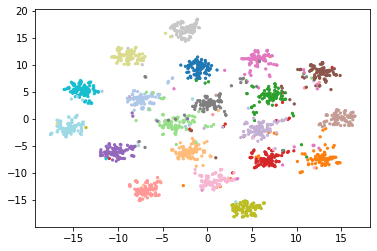

In [59]:
scatter = plt.scatter(tsne_result[:,0], tsne_result[:,1], s = 5,c=first_20_label,cmap='tab20')
# handles, _ = scatter.legend_elements(prop='colors')
# plt.legend(handles, labels)
plt.show()

In [52]:
second_20 = []
for i in range(20):
    if i == 0:
        second_20_data = class_dict[i]
        second_20_label = [i]*len(class_dict[i])
    else:
        second_20_data = np.vstack((second_20_data, class_dict[i]))
        second_20_label += [i]*len(class_dict[i])
second_20_label = np.array(second_20_label)
print(second_20_data.shape, second_20_label.shape)

(2400, 512) (2400,)


In [53]:
n_components = 2
tsne = TSNE(n_components, verbose=1, perplexity=40, n_iter=300)
tsne_result = tsne.fit_transform(second_20_data)
print(tsne_result.shape)

c:\Users\Chen_Xinyan\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Chen_Xinyan\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.001s...
[t-SNE] Computed neighbors for 2400 samples in 0.122s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 6.515959
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.930019
[t-SNE] KL divergence after 300 iterations: 0.914977
(2400, 2)


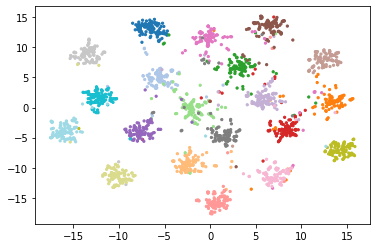

In [56]:
scatter = plt.scatter(tsne_result[:,0], tsne_result[:,1], s = 5, c=second_20_label,cmap='tab20')
# handles, _ = scatter.legend_elements(prop='colors')
# plt.legend(handles, labels)
plt.show()

In [14]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
test(model, test_dataloader, criterion, device)

  1%|          | 2/207 [00:11<19:11,  5.62s/it]


KeyboardInterrupt: 

In [15]:
def train(model, train_loader, test_loader, num_epochs, learning_rate, criterion, device):
    optimizer = torch.optim.AdamW(
        [
                # {'params': model.feature_extractor.parameters()},
                {'params': model.linear_projector.parameters()},
                # {'params': model.vit.parameters()}
                {'params': model.MIT.parameters()}
            ],
        lr = learning_rate
    )
    # optimizer = torch.optim.SGD([
    #             {'params': model.linear_projector.parameters()},
    #             # {'params': model.vit.parameters()}
    #             {'params': model.MIT.parameters()}
    #         ], lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[30,60,90],gamma=0.1)
    parameter_dir = './HAR_13thSep.pt'
    best_test_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        epoch_accuracy = 0
        random.seed(epoch)
        # num_iter = 400
        for i, data in enumerate(tqdm(train_loader)):
            # if i < num_iter:
            mmwave_data, wifi_data, rfid_data, labels, modality_list = data
            if i % 8 == 0:
                modality_list = [False, True, False]
            # print('data')
            # print(rgb_data, depth_data, lidar_data, mmwave_data, wifi_data)
            # print('end')
            mmwave_data = mmwave_data.to(device)
            wifi_data = wifi_data.to(device)
            rfid_data = rfid_data.to(device)
            labels.to(device)
            labels = labels.type(torch.LongTensor)
            
            optimizer.zero_grad()

            outputs = model(mmwave_data, wifi_data,  rfid_data, modality_list)
            outputs = outputs.type(torch.FloatTensor)
            outputs.to(device)
            loss = criterion(outputs,labels)
            if loss == float('nan'):
                print('nan')
                print(outputs)
                print(labels)
                
            loss.backward()
            # print(length)
            # print("loss is ", loss.item())
            optimizer.step()
            
            epoch_loss += loss.item()
            predict_y = torch.argmax(outputs,dim=1).to(device)
            epoch_accuracy += (predict_y == labels.to(device)).sum().item() / labels.size(0)
            # print('accuracy is ', epoch_accuracy)
            # print('loss is ', epoch_loss)
            # else:
            #     break
            # print("epoch loss is ", epoch_loss)
        # epoch_loss = epoch_loss/len(train_loader.dataset)
        epoch_loss = epoch_loss/len(train_loader)
        epoch_accuracy = epoch_accuracy/len(train_loader)
        print('Epoch:{}, Accuracy:{:.4f},Loss:{:.9f}'.format(epoch+1, float(epoch_accuracy),float(epoch_loss)))
        if (epoch+1) % 5 == 0:
            test_acc = test(
                model=model,
                tensor_loader=test_loader,
                criterion = criterion,
                device= device
            )
            if test_acc >= best_test_acc:
                print(f"best test accuracy is:{test_acc}")
                best_test_acc = test_acc
                torch.save(model.state_dict(), parameter_dir)
        # scheduler.step()
    # torch.save(model.state_dict(), parameter_dir)
    return

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) 

cuda:0


In [17]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.load_state_dict(torch.load('./HAR_19thAug_con.pt'))
# model = torch.load('./HAR_15thAug.pt')
model.to(device)
train(
    model=model,
    train_loader= train_dataloader,
    test_loader= test_dataloader,
    num_epochs= 100,
    learning_rate=1e-4,
    criterion=criterion,
    device=device
        )

  0%|          | 1/963 [00:09<2:26:23,  9.13s/it]c:\Users\Chen_Xinyan\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 963/963 [41:40<00:00,  2.60s/it]


Epoch:1, Accuracy:0.4145,Loss:2.398254260


100%|██████████| 963/963 [34:21<00:00,  2.14s/it]


Epoch:2, Accuracy:0.6329,Loss:1.419930831


100%|██████████| 963/963 [33:28<00:00,  2.09s/it]


Epoch:3, Accuracy:0.6624,Loss:1.282585055


100%|██████████| 963/963 [33:14<00:00,  2.07s/it]


Epoch:4, Accuracy:0.6854,Loss:1.172867923


100%|██████████| 963/963 [34:11<00:00,  2.13s/it]


Epoch:5, Accuracy:0.6904,Loss:1.138259034


100%|██████████| 207/207 [12:41<00:00,  3.68s/it]


validation accuracy:0.5699, loss:1.69903
best test accuracy is:0.569897342995169


100%|██████████| 963/963 [38:32<00:00,  2.40s/it]


Epoch:6, Accuracy:0.7186,Loss:1.035174691


100%|██████████| 963/963 [33:58<00:00,  2.12s/it]


Epoch:7, Accuracy:0.7133,Loss:1.038178381


100%|██████████| 963/963 [33:48<00:00,  2.11s/it]


Epoch:8, Accuracy:0.7380,Loss:0.950077505


100%|██████████| 963/963 [33:26<00:00,  2.08s/it]


Epoch:9, Accuracy:0.7361,Loss:0.943904673


100%|██████████| 963/963 [32:51<00:00,  2.05s/it]


Epoch:10, Accuracy:0.7334,Loss:0.954829286


100%|██████████| 207/207 [12:13<00:00,  3.54s/it]


validation accuracy:0.5903, loss:1.72246
best test accuracy is:0.5902777777777778


100%|██████████| 963/963 [36:57<00:00,  2.30s/it]


Epoch:11, Accuracy:0.7429,Loss:0.918370907


100%|██████████| 963/963 [33:06<00:00,  2.06s/it]


Epoch:12, Accuracy:0.7599,Loss:0.857188985


100%|██████████| 963/963 [33:44<00:00,  2.10s/it]


Epoch:13, Accuracy:0.7463,Loss:0.892944494


100%|██████████| 963/963 [33:39<00:00,  2.10s/it]


Epoch:14, Accuracy:0.7625,Loss:0.845710195


100%|██████████| 963/963 [33:35<00:00,  2.09s/it]


Epoch:15, Accuracy:0.7749,Loss:0.796080165


100%|██████████| 207/207 [12:15<00:00,  3.55s/it]


validation accuracy:0.6135, loss:1.59440
best test accuracy is:0.6135265700483091


100%|██████████| 963/963 [37:54<00:00,  2.36s/it]


Epoch:16, Accuracy:0.7543,Loss:0.869148592


100%|██████████| 963/963 [33:19<00:00,  2.08s/it]


Epoch:17, Accuracy:0.7752,Loss:0.789006715


100%|██████████| 963/963 [33:19<00:00,  2.08s/it]


Epoch:18, Accuracy:0.7837,Loss:0.754904446


100%|██████████| 963/963 [33:14<00:00,  2.07s/it]


Epoch:19, Accuracy:0.7836,Loss:0.756915943


100%|██████████| 963/963 [33:21<00:00,  2.08s/it]


Epoch:20, Accuracy:0.7893,Loss:0.723907421


100%|██████████| 207/207 [12:17<00:00,  3.56s/it]


validation accuracy:0.6325, loss:1.54296
best test accuracy is:0.6325483091787439


100%|██████████| 963/963 [37:40<00:00,  2.35s/it]


Epoch:21, Accuracy:0.7847,Loss:0.752737779


100%|██████████| 963/963 [35:34<00:00,  2.22s/it]


Epoch:22, Accuracy:0.7778,Loss:0.766645204


100%|██████████| 963/963 [33:19<00:00,  2.08s/it]


Epoch:23, Accuracy:0.7998,Loss:0.697559349


100%|██████████| 963/963 [33:50<00:00,  2.11s/it]


Epoch:24, Accuracy:0.7999,Loss:0.687850125


100%|██████████| 963/963 [33:40<00:00,  2.10s/it]


Epoch:25, Accuracy:0.7952,Loss:0.721230607


100%|██████████| 207/207 [12:12<00:00,  3.54s/it]


validation accuracy:0.6412, loss:1.50812
best test accuracy is:0.6411533816425121


100%|██████████| 963/963 [37:33<00:00,  2.34s/it]


Epoch:26, Accuracy:0.7964,Loss:0.710019243


100%|██████████| 963/963 [33:37<00:00,  2.10s/it]


Epoch:27, Accuracy:0.8021,Loss:0.695053771


100%|██████████| 963/963 [33:34<00:00,  2.09s/it]


Epoch:28, Accuracy:0.8020,Loss:0.677998862


100%|██████████| 963/963 [33:47<00:00,  2.11s/it]


Epoch:29, Accuracy:0.8159,Loss:0.633068976


100%|██████████| 963/963 [34:02<00:00,  2.12s/it]


Epoch:30, Accuracy:0.8134,Loss:0.642838983


100%|██████████| 207/207 [12:15<00:00,  3.55s/it]


validation accuracy:0.6552, loss:1.49020
best test accuracy is:0.6551932367149759


100%|██████████| 963/963 [37:34<00:00,  2.34s/it]


Epoch:31, Accuracy:0.8098,Loss:0.667244761


100%|██████████| 963/963 [33:17<00:00,  2.07s/it]


Epoch:32, Accuracy:0.8093,Loss:0.658304169


100%|██████████| 963/963 [33:58<00:00,  2.12s/it]


Epoch:33, Accuracy:0.8128,Loss:0.637356822


100%|██████████| 963/963 [33:50<00:00,  2.11s/it]


Epoch:34, Accuracy:0.8278,Loss:0.586733608


100%|██████████| 963/963 [33:28<00:00,  2.09s/it]


Epoch:35, Accuracy:0.8044,Loss:0.660239702


100%|██████████| 207/207 [12:15<00:00,  3.55s/it]


validation accuracy:0.6686, loss:1.44781
best test accuracy is:0.6686292270531401


100%|██████████| 963/963 [37:48<00:00,  2.36s/it]


Epoch:36, Accuracy:0.8231,Loss:0.615010044


100%|██████████| 963/963 [33:47<00:00,  2.11s/it]


Epoch:37, Accuracy:0.8094,Loss:0.656022246


100%|██████████| 963/963 [33:56<00:00,  2.11s/it]


Epoch:38, Accuracy:0.8215,Loss:0.613016874


100%|██████████| 963/963 [33:54<00:00,  2.11s/it]


Epoch:39, Accuracy:0.8281,Loss:0.581283376


100%|██████████| 963/963 [35:25<00:00,  2.21s/it]


Epoch:40, Accuracy:0.8335,Loss:0.564643396


100%|██████████| 207/207 [12:18<00:00,  3.57s/it]


validation accuracy:0.6774, loss:1.40902
best test accuracy is:0.6773852657004831


100%|██████████| 963/963 [37:23<00:00,  2.33s/it]


Epoch:41, Accuracy:0.8447,Loss:0.526256558


100%|██████████| 963/963 [33:40<00:00,  2.10s/it]


Epoch:42, Accuracy:0.8243,Loss:0.594333722


100%|██████████| 963/963 [37:27<00:00,  2.33s/it]


Epoch:43, Accuracy:0.8335,Loss:0.582016564


100%|██████████| 963/963 [34:22<00:00,  2.14s/it]


Epoch:44, Accuracy:0.8435,Loss:0.525560218


100%|██████████| 963/963 [33:50<00:00,  2.11s/it]


Epoch:45, Accuracy:0.8425,Loss:0.532410806


100%|██████████| 207/207 [12:17<00:00,  3.56s/it]


validation accuracy:0.6861, loss:1.36249
best test accuracy is:0.686141304347826


100%|██████████| 963/963 [37:39<00:00,  2.35s/it]


Epoch:46, Accuracy:0.8331,Loss:0.581317573


100%|██████████| 963/963 [34:10<00:00,  2.13s/it]


Epoch:47, Accuracy:0.8496,Loss:0.516584011


100%|██████████| 963/963 [34:20<00:00,  2.14s/it]


Epoch:48, Accuracy:0.8417,Loss:0.545672310


100%|██████████| 963/963 [34:00<00:00,  2.12s/it]


Epoch:49, Accuracy:0.8382,Loss:0.554666034


100%|██████████| 963/963 [33:44<00:00,  2.10s/it]


Epoch:50, Accuracy:0.8436,Loss:0.524783195


100%|██████████| 207/207 [12:22<00:00,  3.59s/it]


validation accuracy:0.6949, loss:1.36477
best test accuracy is:0.694897342995169


100%|██████████| 963/963 [38:08<00:00,  2.38s/it]


Epoch:51, Accuracy:0.8458,Loss:0.527205061


100%|██████████| 963/963 [34:04<00:00,  2.12s/it]


Epoch:52, Accuracy:0.8456,Loss:0.518334001


100%|██████████| 963/963 [34:22<00:00,  2.14s/it]


Epoch:53, Accuracy:0.8528,Loss:0.504851204


100%|██████████| 963/963 [34:15<00:00,  2.13s/it]


Epoch:54, Accuracy:0.8500,Loss:0.511884013


100%|██████████| 963/963 [33:59<00:00,  2.12s/it]


Epoch:55, Accuracy:0.8548,Loss:0.489921136


100%|██████████| 207/207 [12:23<00:00,  3.59s/it]


validation accuracy:0.6842, loss:1.41071


100%|██████████| 963/963 [38:07<00:00,  2.38s/it]


Epoch:56, Accuracy:0.8464,Loss:0.507920742


100%|██████████| 963/963 [33:57<00:00,  2.12s/it]


Epoch:57, Accuracy:0.8609,Loss:0.479743175


100%|██████████| 963/963 [33:53<00:00,  2.11s/it]


Epoch:58, Accuracy:0.8552,Loss:0.494580665


100%|██████████| 963/963 [33:47<00:00,  2.10s/it]


Epoch:59, Accuracy:0.8453,Loss:0.512187656


100%|██████████| 963/963 [33:29<00:00,  2.09s/it]


Epoch:60, Accuracy:0.8599,Loss:0.478221354


100%|██████████| 207/207 [12:29<00:00,  3.62s/it]


validation accuracy:0.6958, loss:1.36859
best test accuracy is:0.6958031400966184


100%|██████████| 963/963 [37:49<00:00,  2.36s/it]


Epoch:61, Accuracy:0.8556,Loss:0.496442193


100%|██████████| 963/963 [32:16<00:00,  2.01s/it]


Epoch:62, Accuracy:0.8616,Loss:0.462915357


100%|██████████| 963/963 [36:06<00:00,  2.25s/it]


Epoch:63, Accuracy:0.8532,Loss:0.492394263


100%|██████████| 963/963 [33:47<00:00,  2.11s/it]


Epoch:64, Accuracy:0.8620,Loss:0.465612565


100%|██████████| 963/963 [33:37<00:00,  2.10s/it]


Epoch:65, Accuracy:0.8590,Loss:0.474342418


100%|██████████| 207/207 [12:31<00:00,  3.63s/it]


validation accuracy:0.7012, loss:1.35891
best test accuracy is:0.701237922705314


100%|██████████| 963/963 [37:03<00:00,  2.31s/it]


Epoch:66, Accuracy:0.8647,Loss:0.454269882


100%|██████████| 963/963 [33:08<00:00,  2.07s/it]


Epoch:67, Accuracy:0.8578,Loss:0.484101755


100%|██████████| 963/963 [33:53<00:00,  2.11s/it]


Epoch:68, Accuracy:0.8664,Loss:0.441449289


100%|██████████| 963/963 [34:00<00:00,  2.12s/it]


Epoch:69, Accuracy:0.8632,Loss:0.461875649


100%|██████████| 963/963 [34:00<00:00,  2.12s/it]


Epoch:70, Accuracy:0.8601,Loss:0.465317814


100%|██████████| 207/207 [12:39<00:00,  3.67s/it]


validation accuracy:0.7117, loss:1.29735
best test accuracy is:0.7116545893719807


100%|██████████| 963/963 [38:30<00:00,  2.40s/it]


Epoch:71, Accuracy:0.8627,Loss:0.454305503


100%|██████████| 963/963 [34:25<00:00,  2.15s/it]


Epoch:72, Accuracy:0.8738,Loss:0.431352620


100%|██████████| 963/963 [39:43<00:00,  2.47s/it]


Epoch:73, Accuracy:0.8668,Loss:0.454113684


100%|██████████| 963/963 [39:24<00:00,  2.46s/it]


Epoch:74, Accuracy:0.8729,Loss:0.427242980


100%|██████████| 963/963 [39:33<00:00,  2.47s/it]


Epoch:75, Accuracy:0.8714,Loss:0.437082040


100%|██████████| 207/207 [15:04<00:00,  4.37s/it]


validation accuracy:0.7062, loss:1.29723


100%|██████████| 963/963 [43:51<00:00,  2.73s/it]


Epoch:76, Accuracy:0.8688,Loss:0.433928761


100%|██████████| 963/963 [40:17<00:00,  2.51s/it]


Epoch:77, Accuracy:0.8742,Loss:0.426052666


100%|██████████| 963/963 [40:26<00:00,  2.52s/it]


Epoch:78, Accuracy:0.8788,Loss:0.401138470


100%|██████████| 963/963 [39:43<00:00,  2.48s/it]


Epoch:79, Accuracy:0.8740,Loss:0.418991023


100%|██████████| 963/963 [39:22<00:00,  2.45s/it]


Epoch:80, Accuracy:0.8797,Loss:0.400978282


100%|██████████| 207/207 [15:16<00:00,  4.43s/it]


validation accuracy:0.7077, loss:1.30277


100%|██████████| 963/963 [42:53<00:00,  2.67s/it]


Epoch:81, Accuracy:0.8746,Loss:0.419958529


100%|██████████| 963/963 [39:03<00:00,  2.43s/it]


Epoch:82, Accuracy:0.8907,Loss:0.362172719


100%|██████████| 963/963 [38:16<00:00,  2.38s/it]


Epoch:83, Accuracy:0.8718,Loss:0.426338860


100%|██████████| 963/963 [35:52<00:00,  2.24s/it]


Epoch:84, Accuracy:0.8635,Loss:0.463237488


100%|██████████| 963/963 [36:04<00:00,  2.25s/it]


Epoch:85, Accuracy:0.8806,Loss:0.401249665


100%|██████████| 207/207 [12:56<00:00,  3.75s/it]


validation accuracy:0.7142, loss:1.26006
best test accuracy is:0.7142210144927537


100%|██████████| 963/963 [39:26<00:00,  2.46s/it]


Epoch:86, Accuracy:0.8825,Loss:0.389282425


100%|██████████| 963/963 [35:59<00:00,  2.24s/it]


Epoch:87, Accuracy:0.8845,Loss:0.394080225


100%|██████████| 963/963 [36:16<00:00,  2.26s/it]


Epoch:88, Accuracy:0.8883,Loss:0.371651838


100%|██████████| 963/963 [36:21<00:00,  2.27s/it]


Epoch:89, Accuracy:0.8810,Loss:0.393028718


100%|██████████| 963/963 [35:55<00:00,  2.24s/it]


Epoch:90, Accuracy:0.8769,Loss:0.410961781


100%|██████████| 207/207 [12:52<00:00,  3.73s/it]


validation accuracy:0.7218, loss:1.25116
best test accuracy is:0.7217693236714976


100%|██████████| 963/963 [38:52<00:00,  2.42s/it]


Epoch:91, Accuracy:0.8742,Loss:0.413936318


100%|██████████| 963/963 [35:40<00:00,  2.22s/it]


Epoch:92, Accuracy:0.8873,Loss:0.379168507


100%|██████████| 963/963 [35:55<00:00,  2.24s/it]


Epoch:93, Accuracy:0.8799,Loss:0.390013104


100%|██████████| 963/963 [35:38<00:00,  2.22s/it]


Epoch:94, Accuracy:0.8853,Loss:0.379190489


100%|██████████| 963/963 [36:10<00:00,  2.25s/it]


Epoch:95, Accuracy:0.8942,Loss:0.354908255


100%|██████████| 207/207 [12:48<00:00,  3.71s/it]


validation accuracy:0.7258, loss:1.21719
best test accuracy is:0.7258454106280193


100%|██████████| 963/963 [39:45<00:00,  2.48s/it]


Epoch:96, Accuracy:0.8806,Loss:0.390445560


100%|██████████| 963/963 [36:27<00:00,  2.27s/it]


Epoch:97, Accuracy:0.8895,Loss:0.368825932


100%|██████████| 963/963 [36:36<00:00,  2.28s/it]


Epoch:98, Accuracy:0.8810,Loss:0.395093475


100%|██████████| 963/963 [36:37<00:00,  2.28s/it]


Epoch:99, Accuracy:0.8848,Loss:0.383131095


100%|██████████| 963/963 [36:22<00:00,  2.27s/it]


Epoch:100, Accuracy:0.8926,Loss:0.349516076


100%|██████████| 207/207 [12:48<00:00,  3.71s/it]

validation accuracy:0.7246, loss:1.20160


In [18]:
def multi_test(model, tensor_loader, criterion, device):
    model.eval()
    mmwave_test_loss = 0
    mmwave_test_accuracy = 0

    wifi_test_loss = 0
    wifi_test_accuracy = 0
    
    rfid_test_loss = 0
    rfid_test_accuracy = 0

    mmwave_wifi_test_loss = 0
    mmwave_wifi_test_accuracy = 0

    mmwave_rfid_test_loss = 0
    mmwave_rfid_test_accuracy = 0

    wifi_rfid_test_loss = 0
    wifi_rfid_test_accuracy = 0

    mmwave_wifi_rfid_test_loss = 0
    mmwave_wifi_rfid_test_accuracy = 0

    # random.seed(config['modality_existances']['val_random_seed'])
    for data in tqdm(tensor_loader):
        start_time = time.time()
        mmwave_data, wifi_data, rfid_data, labels, modality_list = data
        # t1 = time.time()
        # load_time = t1 - start_time 
        mmwave_data = mmwave_data.to(device)
        wifi_data = wifi_data.to(device)
        rfid_data = rfid_data.to(device)
        labels.to(device)
        labels = labels.type(torch.LongTensor)


        ' SINGLE MODALITY '
        ### mmwave
        mmwave_modality_list = [True, False, False]
        mmwave_outputs = model(mmwave_data, wifi_data,  rfid_data, mmwave_modality_list)
        mmwave_outputs = mmwave_outputs.type(torch.FloatTensor)
        mmwave_outputs.to(device)
        mmwave_test_loss += criterion(mmwave_outputs,labels).item() * mmwave_data.size(0)
        mmwave_predict_y = torch.argmax(mmwave_outputs,dim=1).to(device)
        mmwave_test_accuracy += (mmwave_predict_y == labels.to(device)).sum().item() / labels.size(0)
        mmwave_outputs = mmwave_outputs.detach().cpu()
        mmwave_predict_y = mmwave_predict_y.detach().cpu()
        ### wifi-cis
        wifi_modality_list = [False, True, False]
        wifi_outputs = model(mmwave_data, wifi_data,  rfid_data, wifi_modality_list)
        wifi_outputs = wifi_outputs.type(torch.FloatTensor)
        wifi_outputs.to(device)
        wifi_test_loss += criterion(wifi_outputs,labels).item() * wifi_data.size(0)
        wifi_predict_y = torch.argmax(wifi_outputs,dim=1).to(device)
        wifi_test_accuracy += (wifi_predict_y == labels.to(device)).sum().item() / labels.size(0)
        wifi_outputs = wifi_outputs.detach().cpu()
        wifi_predict_y = wifi_predict_y.detach().cpu()
        ### rfid
        rfid_modality_list = [False, False,True]
        rfid_outputs = model(mmwave_data, wifi_data,  rfid_data, rfid_modality_list)
        rfid_outputs = rfid_outputs.type(torch.FloatTensor)
        rfid_outputs.to(device)
        rfid_test_loss += criterion(rfid_outputs,labels).item() * rfid_data.size(0)
        rfid_predict_y = torch.argmax(rfid_outputs,dim=1).to(device)
        rfid_test_accuracy += (rfid_predict_y == labels.to(device)).sum().item() / labels.size(0)
        rfid_outputs = rfid_outputs.detach().cpu()
        rfid_predict_y = rfid_predict_y.detach().cpu()
        
        'Dual modality'
        ### mmwave + wifi
        mmwave_wifi_modality_list = [True, True, False]
        mmwave_wifi_outputs = model(mmwave_data, wifi_data,  rfid_data, mmwave_wifi_modality_list)
        mmwave_wifi_outputs = mmwave_wifi_outputs.type(torch.FloatTensor)
        mmwave_wifi_outputs.to(device)
        mmwave_wifi_test_loss += criterion(mmwave_wifi_outputs,labels).item() * mmwave_data.size(0)
        mmwave_wifi_predict_y = torch.argmax(mmwave_wifi_outputs,dim=1).to(device)
        mmwave_wifi_test_accuracy += (mmwave_wifi_predict_y == labels.to(device)).sum().item() / labels.size(0)
        mmwave_wifi_outputs = mmwave_wifi_outputs.detach().cpu()
        mmwave_wifi_predict_y = mmwave_wifi_predict_y.detach().cpu()

        ### mmwave + rfid
        mmwave_rfid_modality_list = [True, False, True]
        mmwave_rfid_outputs = model(mmwave_data, wifi_data,  rfid_data, mmwave_rfid_modality_list)
        mmwave_rfid_outputs = mmwave_rfid_outputs.type(torch.FloatTensor)
        mmwave_rfid_outputs.to(device)
        mmwave_rfid_test_loss += criterion(mmwave_rfid_outputs,labels).item() * mmwave_data.size(0)
        mmwave_rfid_predict_y = torch.argmax(mmwave_rfid_outputs,dim=1).to(device)
        mmwave_rfid_test_accuracy += (mmwave_rfid_predict_y == labels.to(device)).sum().item() / labels.size(0)
        mmwave_rfid_outputs = mmwave_rfid_outputs.detach().cpu()
        mmwave_rfid_predict_y = mmwave_rfid_predict_y.detach().cpu()

        ### wifi + rfid
        wifi_rfid_modality_list = [False, True, True]
        wifi_rfid_outputs = model(mmwave_data, wifi_data,  rfid_data, wifi_rfid_modality_list)
        wifi_rfid_outputs = wifi_rfid_outputs.type(torch.FloatTensor)
        wifi_rfid_outputs.to(device)
        wifi_rfid_test_loss += criterion(wifi_rfid_outputs,labels).item() * wifi_data.size(0)
        wifi_rfid_predict_y = torch.argmax(wifi_rfid_outputs,dim=1).to(device)
        wifi_rfid_test_accuracy += (wifi_rfid_predict_y == labels.to(device)).sum().item() / labels.size(0)
        wifi_rfid_outputs = wifi_rfid_outputs.detach().cpu()
        wifi_rfid_predict_y = wifi_rfid_predict_y.detach().cpu()

        'Three modality'
        ### mmwave + wifi + rfid
        mmwave_wifi_rfid_modality_list = [True, True, True]
        mmwave_wifi_rfid_outputs = model(mmwave_data, wifi_data,  rfid_data, mmwave_wifi_rfid_modality_list)
        mmwave_wifi_rfid_outputs = mmwave_wifi_rfid_outputs.type(torch.FloatTensor)
        mmwave_wifi_rfid_outputs.to(device)
        mmwave_wifi_rfid_test_loss += criterion(mmwave_wifi_rfid_outputs,labels).item() * mmwave_data.size(0)
        mmwave_wifi_rfid_predict_y = torch.argmax(mmwave_wifi_rfid_outputs,dim=1).to(device)
        mmwave_wifi_rfid_test_accuracy += (mmwave_wifi_rfid_predict_y == labels.to(device)).sum().item() / labels.size(0)
        mmwave_wifi_rfid_outputs = mmwave_wifi_rfid_outputs.detach().cpu()
        mmwave_wifi_rfid_predict_y = mmwave_wifi_rfid_predict_y.detach().cpu()


    'single modality'
    ### mmwave
    mmwave_test_loss = mmwave_test_loss/len(tensor_loader.dataset)
    mmwave_test_accuracy = mmwave_test_accuracy/len(tensor_loader)
    print("modality: {}, Cross Entropy Loss: {:.8f}, Accuracy: {:.8f}".format('mmWave',float(mmwave_test_loss), float(mmwave_test_accuracy)))
    ### wifi
    wifi_test_loss = wifi_test_loss/len(tensor_loader.dataset)
    wifi_test_accuracy = wifi_test_accuracy/len(tensor_loader)
    print("modality: {}, Cross Entropy Loss: {:.8f}, Accuracy: {:.8f}\n".format('WiFi-CSI',float(wifi_test_loss), float(wifi_test_accuracy)))
    ### rfid
    rfid_test_loss = rfid_test_loss/len(tensor_loader.dataset)
    rfid_test_accuracy = rfid_test_accuracy/len(tensor_loader)
    print("modality: {}, Cross Entropy Loss: {:.8f}, Accuracy: {:.8f}\n".format('RFID',float(rfid_test_loss), float(rfid_test_accuracy)))

    'dual modality'
    ### mmwave + wifi
    mmwave_wifi_test_loss = mmwave_wifi_test_loss/len(tensor_loader.dataset)
    mmwave_wifi_test_accuracy = mmwave_wifi_test_accuracy/len(tensor_loader)
    print("modality: {}, Cross Entropy Loss: {:.8f}, Accuracy: {:.8f}".format('mmWave+WiFi-CSI',float(mmwave_wifi_test_loss), float(mmwave_wifi_test_accuracy)))
    
    ### mmwave + rfid
    mmwave_rfid_test_loss = mmwave_rfid_test_loss/len(tensor_loader.dataset)
    mmwave_rfid_test_accuracy = mmwave_rfid_test_accuracy/len(tensor_loader)
    print("modality: {}, Cross Entropy Loss: {:.8f}, Accuracy: {:.8f}".format('mmWave+RFID',float(mmwave_rfid_test_loss), float(mmwave_rfid_test_accuracy)))

    ### wifi + rfid
    wifi_rfid_test_loss = wifi_rfid_test_loss/len(tensor_loader.dataset)
    wifi_rfid_test_accuracy = wifi_rfid_test_accuracy/len(tensor_loader)
    print("modality: {}, Cross Entropy Loss: {:.8f}, Accuracy: {:.8f}".format('WiFi-CSI+RFID',float(wifi_rfid_test_loss), float(wifi_rfid_test_accuracy)))

    'three modality'
    ### mmwave + wifi + rfid
    mmwave_wifi_rfid_test_loss = mmwave_wifi_rfid_test_loss/len(tensor_loader.dataset)
    mmwave_wifi_rfid_test_accuracy = mmwave_wifi_rfid_test_accuracy/len(tensor_loader)
    print("modality: {}, Cross Entropy Loss: {:.8f}, Accuracy: {:.8f}".format('mmWave+WiFi-CSI+RFID',float(mmwave_wifi_rfid_test_loss), float(mmwave_wifi_rfid_test_accuracy)))
    return

In [19]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load('./HAR_13thSep.pt'))

multi_test(model, test_dataloader, criterion, device)

100%|██████████| 207/207 [12:28<00:00,  3.62s/it]

modality: mmWave, Cross Entropy Loss: 1.10815057, Accuracy: 0.80857488
modality: WiFi-CSI, Cross Entropy Loss: 1.53563757, Accuracy: 0.57276570

modality: RFID, Cross Entropy Loss: 3.85244744, Accuracy: 0.40126812

modality: mmWave+WiFi-CSI, Cross Entropy Loss: 0.57893761, Accuracy: 0.87303744
modality: mmWave+RFID, Cross Entropy Loss: 0.73271097, Accuracy: 0.84842995
modality: WiFi-CSI+RFID, Cross Entropy Loss: 1.71662585, Accuracy: 0.61201691
modality: mmWave+WiFi-CSI+RFID, Cross Entropy Loss: 0.47651144, Accuracy: 0.88798309


In [15]:
# model.detach()
parameter_dir = './HAR_4thJun.pt'
torch.save(model.state_dict(), parameter_dir)

In [13]:
print(list(model.feature_extractor.csi_extractor.parameters()))
class csi_feature_extractor(nn.Module):
    def __init__(self, model):
        super(csi_feature_extractor, self).__init__()
        self.part = nn.Sequential(
            model.encoder_conv1,
            model.encoder_bn1,
            model.encoder_relu,
            model.encoder_layer1,
            model.encoder_layer2,
            model.encoder_layer3,
            model.encoder_layer4, 
            # torch.nn.AvgPool2d((1, 4))
        )
    def forward(self, x):
        x = x.unsqueeze(1)
        x = torch.transpose(x, 2, 3) #16,2,114,3,32
        x = torch.flatten(x, 3, 4)# 16,2,114,96
        torch_resize = Resize([136,32])
        x = torch_resize(x)
        x = self.part(x).view(x.size(0), 512, -1)
        x = x.permute(0, 2, 1)
        return x
import sys
sys.path.insert(0, './CSI_benchmark')
csi_model = torch.load('CSI_benchmark/protocol3_random_1.pkl')
csi_extractor = csi_feature_extractor(csi_model)
csi_extractor.eval()
print("original model:")
print(list(csi_extractor.parameters()))

[Parameter containing:
tensor([[[[ 0.1442, -0.0400,  0.0629],
          [-0.1392,  0.0949,  0.2094],
          [ 0.0652, -0.2481, -0.3184]]],


        [[[ 0.0702, -0.2592, -0.1461],
          [ 0.0290, -0.2670, -0.1601],
          [-0.0984, -0.1065,  0.1317]]],


        [[[-0.2569, -0.1761, -0.2460],
          [-0.0025,  0.0818, -0.1916],
          [ 0.0658,  0.0344, -0.1465]]],


        [[[ 0.1116, -0.2394, -0.2183],
          [-0.0552, -0.1350, -0.1518],
          [ 0.0485, -0.0301, -0.2722]]],


        [[[ 0.1532, -0.1014, -0.0618],
          [ 0.3229, -0.0714,  0.1710],
          [-0.1570,  0.2686,  0.3306]]],


        [[[ 0.1332, -0.3275, -0.0421],
          [-0.2583, -0.3117, -0.2423],
          [-0.1054,  0.2280,  0.0535]]],


        [[[-0.1630, -0.1043,  0.2208],
          [ 0.1549, -0.2130,  0.0888],
          [-0.1122, -0.2864,  0.3296]]],


        [[[ 0.2309, -0.1619, -0.2679],
          [-0.2516,  0.0649,  0.2708],
          [ 0.0679, -0.0229, -0.0502]]],


        [

: 